In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import readligo as rl
from gwpy.timeseries import TimeSeries
import math
import random

In [47]:
# class TimeDistributed(nn.Module):
#     def __init__(self, layer):
#         super(TimeDistributed, self).__init__()
#         self.layer = layer

#     def forward(self, x):
#         # 获取输入张量的形状
#         input_shape = x.size()

#         # 将张量展平为(batch_size * seq_len, ...)
#         x = x.view(-1, input_shape[-1])

#         # 将层应用于每个时间步
#         x = self.layer(x)

#         # 将输出张量重新调整为(batch_size, seq_len, ...)
#         output_shape = list(input_shape[:-1]) + [x.size(-1)]
#         x = x.view(*output_shape)

#         return x

In [48]:
# class LSTMAutoencoder(nn.Module):
#     def __init__(self):
#         super(LSTMAutoencoder, self).__init__()

#         self.encoder_layer1 = nn.LSTM(1, 32, batch_first=True)  # 第一层编码器
#         self.encoder_layer2 = nn.LSTM(32, 8, batch_first=True)  # 第二层编码器


#         self.decoder_layer1 = nn.LSTM(8, 32, batch_first=True)  # 第一层解码器


#     def forward(self, x):
#         # 编码器
#         encoded_seq, _ = self.encoder_layer1(x)  # 第一层编码器输出
#         encoded_seq, _ = self.encoder_layer2(encoded_seq)  # 第二层编码器输出
        
#         x = x[:, -1, :].unsqueeze(1)
#         x = x.repeat(1, 100, 1)

#         # 解码器
#         decoded_seq, _ = self.decoder_layer1(encoded_seq)  # 第一层解码器输出

        
#         return decoded_seq

In [2]:
class TimeDistributed(nn.Module):
    def __init__(self, layer):
        super(TimeDistributed, self).__init__()
        self.layer = layer

    def forward(self, x):
        batch_size, time_steps, features = x.size()
        x = x.reshape(-1, features)
        outputs = self.layer(x)
        outputs = outputs.view(batch_size, time_steps, -1)
        return outputs

class LSTMAutoencoder(nn.Module):
    def __init__(self):
        super(LSTMAutoencoder, self).__init__()

        self.encoder_layer1 = nn.LSTM(1, 32, batch_first=True)  # 第一层编码器
        self.encoder_layer2 = nn.LSTM(32, 8, batch_first=True)  # 第二层编码器


        self.decoder_layer1 = nn.LSTM(8, 32, batch_first=True)  # 第一层解码器
        self.time_distributed = TimeDistributed(nn.Linear(32,1))


    def forward(self, x):
        # 编码器
        encoded_seq, _ = self.encoder_layer1(x)  # 第一层编码器输出
        encoded_seq, _ = self.encoder_layer2(encoded_seq)  # 第二层编码器输出
        
        if len(x.size()) == 3:

            x = x[:, -1, :].unsqueeze(1)
            x = x.repeat(1, 200, 1)

        elif len(x.size()) == 2:

            x = x[-1].unsqueeze(0)
            x = x.repeat(200, 1)

        # 解码器
        decoded_seq, _ = self.decoder_layer1(encoded_seq)  # 第一层解码器输出
        decoded_seq = self.time_distributed(decoded_seq)

        
        return decoded_seq

In [65]:
# class MultiLinear(nn.Module):
#     def __init__(self, in_features, out_features, num_layers):
#         super(MultiLinear, self).__init__()
#         self.layers = nn.ModuleList([nn.Linear(in_features, out_features) for i in range(num_layers)])

#     def forward(self, x):
#         x_copy = x.clone()
#         for i in range(len(self.layers)):
#             x_copy[:, i:i+1, :] = self.layers[i](x[:, i:i+1, :]).squeeze()
#         return x_copy

# class TimeDistributed(nn.Module):
#     def __init__(self, layer):
#         super(TimeDistributed, self).__init__()
#         self.layer = layer

#     def forward(self, x):
#         # 获取输入张量的形状
#         input_shape = x.size()

#         # 将张量展平为(batch_size * seq_len, ...)
#         # x = x.reshape(-1, input_shape[-1])

#         x_copy = x.clone()

#         # 将层应用于每个时间步
#         y = self.layer(x_copy)

#         # 将输出张量重新调整为(batch_size, seq_len, ...)
#         output_shape = list(input_shape[:-1]) + [y.size(-1)]
#         y = y.view(*output_shape)

#         return y

# class LSTMAutoencoder(nn.Module):
#     def __init__(self):
#         super(LSTMAutoencoder, self).__init__()

#         self.encoder_layer1 = nn.LSTM(1, 32, batch_first=True)  # 第一层编码器
#         self.encoder_layer2 = nn.LSTM(32, 8, batch_first=True)  # 第二层编码器
#         self.decoder_layer1 = nn.LSTM(8, 32, batch_first=True)  # 第一层解码器
#         self.time_distributed = TimeDistributed(MultiLinear(32, 1, 100))

#     def forward(self, x):
#         # 编码器
#         encoded_seq, _ = self.encoder_layer1(x)  # 第一层编码器输出
#         encoded_seq, _ = self.encoder_layer2(encoded_seq)  # 第二层编码器输出

#         x = x[:, -1, :].unsqueeze(1)
#         x = x.repeat(1, 100, 1)

#         # 解码器
#         decoded_seq, _ = self.decoder_layer1(encoded_seq)  # 第一层解码器输出
#         decoded_seq = self.time_distributed(decoded_seq)

#         return decoded_seq

In [3]:
epochs = 200
test_sample_ratio = .2
validation_sample_ratio = 0.1
input_vector_length = 200
batch_size = 32
num_bins = 40
coef_delta = 0

In [4]:
def min_max_minus1_normalization(v):
    v_flattened = v.flatten()
    coef = (max(v_flattened)-min(v_flattened)) / 2
    minimal = (max(v_flattened) + min(v_flattened)) / 2
    v_normalized = (v.copy() - minimal) / coef
    return v_normalized, minimal, coef

In [5]:
def bunch_min_max_minus1_normalization(v):
    
    v_normalized = v.copy()
    minimal = np.zeros(len(v))
    coef = np.zeros(len(v))
    
    for i in range(len(v)):
        v_normalized[i], minimal[i], coef[i]= min_max_minus1_normalization(v[i])
    
    return v_normalized, minimal, coef

In [6]:
def standarization(realbkg_trimmed):
    realbkg_trimmed = (realbkg_trimmed - np.transpose([np.mean(realbkg_trimmed, axis=1)]))/np.transpose([np.std(realbkg_trimmed, axis=1)])
    return realbkg_trimmed

In [7]:
def count_trainable_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

# 示例用法
model = LSTMAutoencoder()  # 替换为你的模型
total_params = count_trainable_parameters(model)
print("Total trainable parameters in the model:", total_params)

Total trainable parameters in the model: 11233


In [357]:
data_for_training_and_testing = np.load("../Data_cached/4000Hz25msnoisesample.npy")

In [28]:
data_for_training_and_testing = np.load("../Data_cached/4000Hz25msnoisesample1e6.npy")

In [6]:
data_for_training_and_testing = np.load('../Data_cached/real_bkg_1e5_6000s_4000Hz_25ms_new_dataset_p1_full_random.npy')
np.random.shuffle(data_for_training_and_testing)

In [5]:
data_for_training_and_testing = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/background.npz')['data'][:,0,:]

In [8]:
data_for_training_and_testing = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy')[:,0,:][:70000]

In [6]:
data_injected = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy')[:,0,:]

In [19]:
data_injected = np.load('../Data_cached/injected_BBH_3e3_snr8-384.npy')

In [23]:
data_injected = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy')[:,0,:][70000:]

In [24]:
data_noise = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/background.npz')['data'][:,0,:]

In [9]:
total_sample_number = data_for_training_and_testing.shape[0]
test_sample_number = int(test_sample_ratio * total_sample_number)
validation_sample_number = int(validation_sample_ratio * total_sample_number)
train_sample_number = total_sample_number - test_sample_number - validation_sample_number


X_train_ini = data_for_training_and_testing[0:train_sample_number].copy()
X_test_ini = data_for_training_and_testing[-test_sample_number:].copy()
X_validation_ini = data_for_training_and_testing[train_sample_number:-test_sample_number].copy()

In [10]:
X_train, X_train_recover_min, X_train_recover_coef = min_max_minus1_normalization(X_train_ini)
X_test, X_test_recover_min, X_test_recover_coef = min_max_minus1_normalization(X_test_ini)
X_validation, X_validation_recover_min, X_validation_recover_coef = min_max_minus1_normalization(X_validation_ini)
data_injected_normalized, junk1, junk2 = min_max_minus1_normalization(data_injected.copy())

NameError: name 'data_injected' is not defined

In [11]:
X_train = standarization(X_train_ini)
X_test = standarization(X_test_ini)
X_validation = standarization(X_validation_ini)

In [20]:
data_injected_normalized = standarization(data_injected)

In [25]:
X_train, X_train_recover_min, X_train_recover_coef = bunch_min_max_minus1_normalization(X_train_ini)
X_test, X_test_recover_min, X_test_recover_coef = bunch_min_max_minus1_normalization(X_test_ini)
X_validation, X_validation_recover_min, X_validation_recover_coef = bunch_min_max_minus1_normalization(X_validation_ini)
data_injected_normalized, junk1, junk2 = bunch_min_max_minus1_normalization(data_injected)

In [26]:
data_noise_normalized, _, _ = bunch_min_max_minus1_normalization(data_noise)

In [13]:
trainData = torch.FloatTensor(X_train)
testData = torch.FloatTensor(X_test)
validationData = torch.FloatTensor(X_validation)

In [14]:
train_dataset = TensorDataset(trainData, trainData)
test_dataset = TensorDataset(testData, testData)
validation_dataset = TensorDataset(validationData, validationData)

trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)


autoencoder = LSTMAutoencoder().cuda()
torch.autograd.set_detect_anomaly(True)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0005)
loss_func = nn.MSELoss().cuda()
loss_train = np.zeros((epochs, 1))
loss_validation = np.zeros((epochs, 1))


for epoch in range(epochs):
    # 训练阶段
    autoencoder.train()
    for batchidx, (x, _) in enumerate(trainDataLoader):
        x = x.cuda()
        x = x.unsqueeze(2)
        decoded = autoencoder(x)
        # weighted_lossTrain = loss_func(decoded, x)
        loss_overall = loss_func(decoded, x)
        loss_norm = loss_func(decoded[:, -1], x[:, -1])
        weighted_lossTrain = loss_overall + loss_norm * coef_delta
        
        # output_norm = torch.norm(decoded[:, :100], dim=1) 
        # penalty_term = torch.mean((output_norm - 1) ** 2) 
        # weighted_lossTrain = lossTrain + coef_delta * penalty_term
        
        optimizer.zero_grad()
        weighted_lossTrain.backward()
        optimizer.step()

    # 验证阶段
    autoencoder.eval()
    with torch.no_grad():
        val_loss = 0
        for batchidx, (x, _) in enumerate(validationDataLoader):
            x = x.cuda()
            x = x.unsqueeze(2)
            decoded = autoencoder(x)
            lossVal_overall = loss_func(decoded, x)
            lossVal_norm = loss_func(decoded[:, -1], x[:, -1])
            lossVal = lossVal_overall + lossVal_norm * coef_delta
            val_loss += lossVal.item()

        val_loss /= len(validationDataLoader)
    
    loss_train[epoch,0] = weighted_lossTrain.item()
    loss_validation[epoch,0] = val_loss
    print('Epoch: %04d, Training loss=%.8f, Validation loss=%.8f' % (epoch+1, weighted_lossTrain.item(), val_loss))

Epoch: 0001, Training loss=0.00009422, Validation loss=0.00019073
Epoch: 0002, Training loss=0.00002082, Validation loss=0.00002335
Epoch: 0003, Training loss=0.00000881, Validation loss=0.00001156
Epoch: 0004, Training loss=0.00000315, Validation loss=0.00000464
Epoch: 0005, Training loss=0.00000941, Validation loss=0.00000994
Epoch: 0006, Training loss=0.00000110, Validation loss=0.00000201
Epoch: 0007, Training loss=0.00000252, Validation loss=0.00000428
Epoch: 0008, Training loss=0.00000292, Validation loss=0.00000578
Epoch: 0009, Training loss=0.00000052, Validation loss=0.00000072
Epoch: 0010, Training loss=0.00013778, Validation loss=0.00000922
Epoch: 0011, Training loss=0.00000044, Validation loss=0.00000055
Epoch: 0012, Training loss=0.00000573, Validation loss=0.00000592
Epoch: 0013, Training loss=0.00000037, Validation loss=0.00000039
Epoch: 0014, Training loss=0.00000037, Validation loss=0.00000038
Epoch: 0015, Training loss=0.00000318, Validation loss=0.00000299
Epoch: 001

In [195]:
autoencoder.cpu()

LSTMAutoencoder(
  (encoder_layer1): LSTM(1, 32, batch_first=True)
  (encoder_layer2): LSTM(32, 8, batch_first=True)
  (decoder_layer1): LSTM(8, 32, batch_first=True)
  (time_distributed): TimeDistributed(
    (layer): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [21]:
os.chdir('D://Onedrive - HKUST connect/Research/GWNMMAD/codes')

In [22]:
torch.save(autoencoder.cpu(), '../Model_cached/model_LSTM_32-8-8-32_GWAK_BBH.pt')

In [355]:
autoencoder = torch.load('../Model_cached/model_LSTM_32-8-8-32_1.pt')

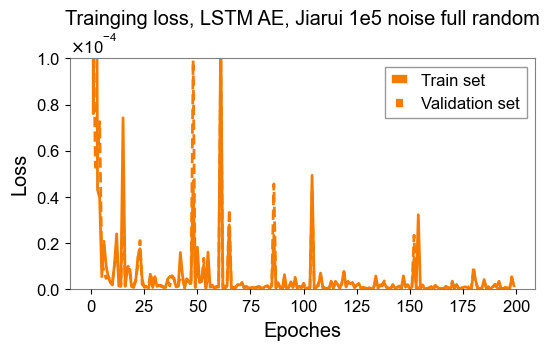

In [18]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, LSTM AE, Jiarui 1e5 noise full random')
plt.ylim(0,1e-4)
plt.legend()
plt.show()

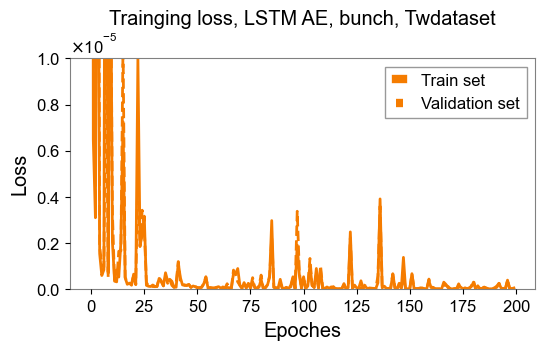

In [16]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, LSTM AE, bunch, Twdataset')
plt.ylim(0,1e-5)
plt.legend()
plt.show()

NameError: name 'loss_train' is not defined

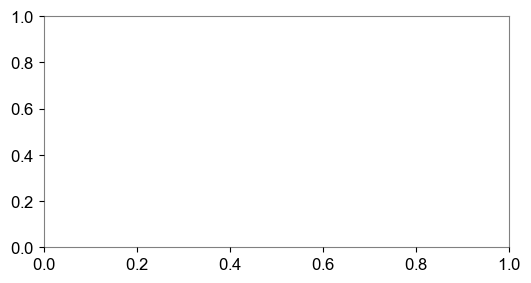

In [354]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, LSTM AE, bunch')
plt.ylim(0,1e-6)
plt.legend()
plt.show()

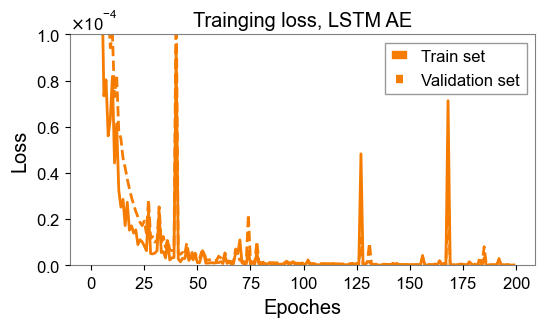

In [85]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, LSTM AE')
plt.ylim(0,1e-4)
plt.legend()
plt.show()

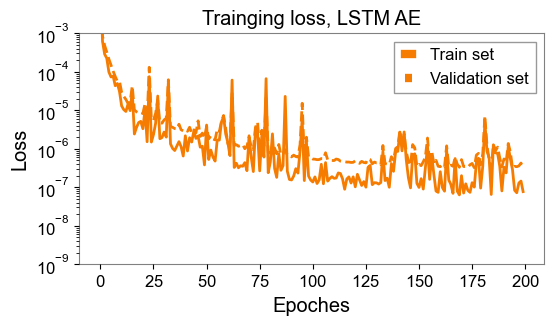

In [190]:
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)
ax.grid()
ax.plot(loss_train, color=[245/255, 124/255, 0/255], linestyle='-', linewidth=2, label = 'Train set') 
ax.plot(loss_validation, color=[245/255, 124/255, 0/255], linestyle='--', linewidth=2, label = 'Validation set') 
ax.set_xlabel('Epoches')
ax.set_ylabel('Loss')
ax.set_title('Trainging loss, LSTM AE')
plt.ylim(1e-9, 1e-3)
plt.legend()
plt.yscale('log')
plt.show()

In [21]:
decodedTestdata = autoencoder(trainData.unsqueeze(2))
decodedTestdata = decodedTestdata.double()
reconstructedData_train = decodedTestdata.detach().numpy()
ReconstructedError_train = torch.mean(((trainData.unsqueeze(2) - reconstructedData_train)**2),dim=1)
MSE_train = ReconstructedError_train.mean()

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 34173440000 bytes.

In [22]:
reconstructedData_train = np.zeros((0, input_vector_length))
ReconstructedError_train = np.zeros((0))

Reconstruction_batchsize = input_vector_length
trainData_batched = trainData.reshape(-1, Reconstruction_batchsize, input_vector_length)

for i in range(trainData_batched.shape[0]):
    decodedTestdata = autoencoder(trainData_batched[i].unsqueeze(2))
    decodedTestdata = decodedTestdata.double()
    reconstructedData_train_intermediate = decodedTestdata.detach().numpy()
    ReconstructedError_train_intermediate = torch.mean(((trainData_batched[i].unsqueeze(2) - reconstructedData_train_intermediate)**2),dim=1)

    reconstructedData_train = np.append(reconstructedData_train, reconstructedData_train_intermediate)
    ReconstructedError_train = np.append(ReconstructedError_train, ReconstructedError_train_intermediate)

MSE_train = ReconstructedError_train.mean()

In [38]:
ReconstructedError_train.shape

(700000,)

In [125]:
trainData[0].unsqueeze(1).unsqueeze(0).shape

torch.Size([1, 100, 1])

In [295]:
reconstructedData_train = reconstructedData_train.reshape(700000, -1)

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

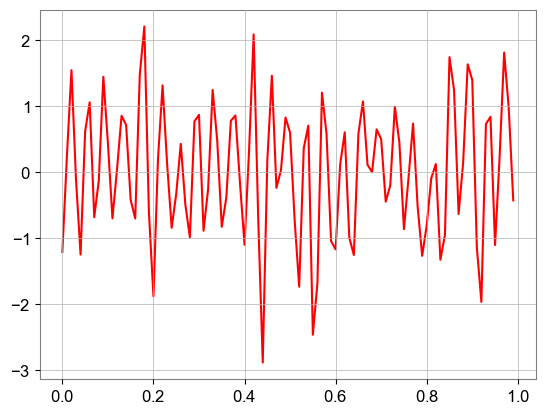

In [33]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,1,1/100)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_train[6999]


plt.plot(x, trainData[6999].numpy().flatten()[0:100], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:100], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

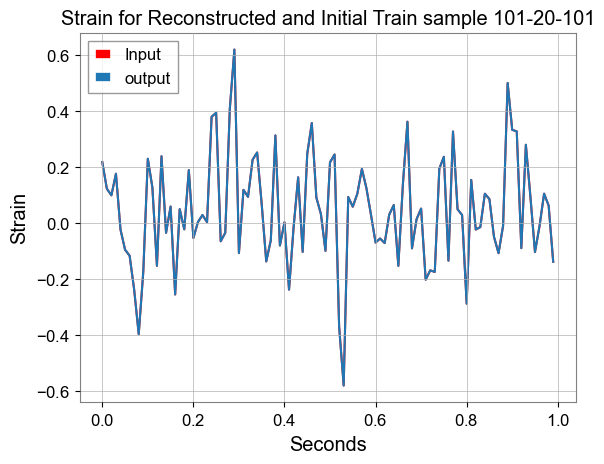

In [46]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,1,1/100)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_train[699999]


plt.plot(x, trainData[699999].numpy().flatten()[0:100], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:100], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

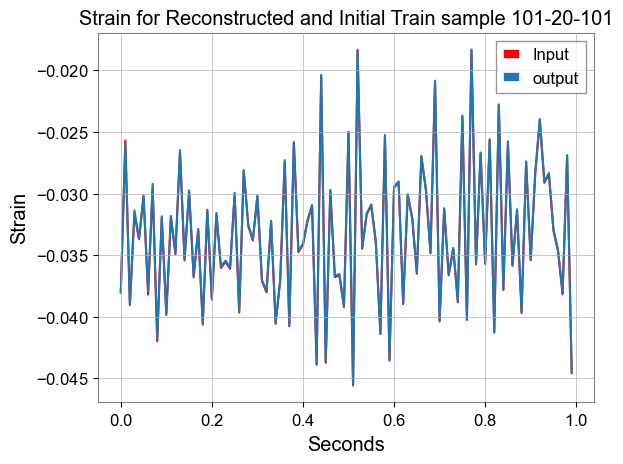

In [198]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,1,1/100)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_train


plt.plot(x, trainData[0].numpy().flatten()[0:100], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:100], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial Train sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

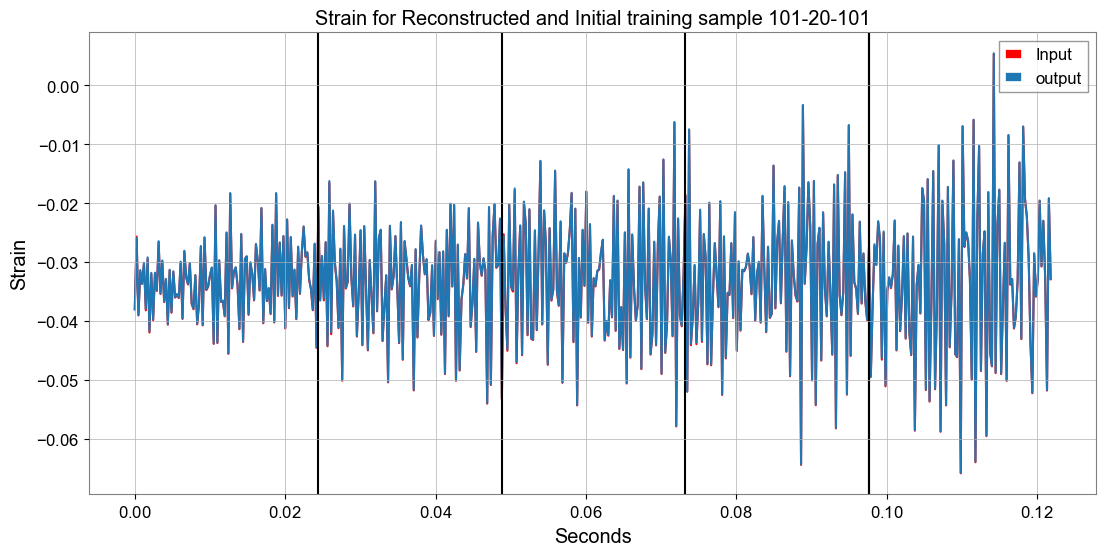

In [199]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_train

plt.figure(figsize=(13,6))
plt.plot(x, trainData.numpy().flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial training sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [363]:
decodedTestdata = autoencoder(testData.unsqueeze(2))
decodedTestdata = decodedTestdata.double()
reconstructedData_test = decodedTestdata.detach().numpy()
ReconstructedError_test = torch.mean(((testData.unsqueeze(2) - reconstructedData_test)**2),dim=1)
MSE_test = ReconstructedError_test.mean()

In [143]:
1

1

In [23]:
reconstructedData_test = np.zeros((0, input_vector_length))
ReconstructedError_test = np.zeros((0))

Reconstruction_batchsize = input_vector_length
testData_batched = testData.reshape(-1, Reconstruction_batchsize, input_vector_length)

for i in range(testData_batched.shape[0]):
    decodedTestdata = autoencoder(testData_batched[i].unsqueeze(2))
    decodedTestdata = decodedTestdata.double()
    reconstructedData_test_intermediate = decodedTestdata.detach().numpy()
    ReconstructedError_test_intermediate = torch.mean(((testData_batched[i].unsqueeze(2) - reconstructedData_test_intermediate)**2),dim=1)

    reconstructedData_test = np.append(reconstructedData_test, reconstructedData_test_intermediate)
    ReconstructedError_test = np.append(ReconstructedError_test, ReconstructedError_test_intermediate)

MSE_test = ReconstructedError_test.mean()

In [297]:
reconstructedData_test.reshape(200000, 100)

array([[ 0.02915273,  0.14345236, -0.31848308, ...,
         0.40739188, -0.00856322, -0.03974089],
       [ 0.063467  ,  0.10033391,  0.10729772, ...,
        -0.1771185 ,  0.01377583,  0.30010715],
       [ 0.0595743 ,  0.34768376,  0.06568608, ...,
         0.2829093 ,  0.07119469,  0.03892733],
       ...,
       [ 0.22007321, -0.04884653,  0.37054029, ...,
        -0.0464416 ,  0.21319386,  0.19084455],
       [ 0.13371602,  0.22683033,  0.20156333, ...,
         0.08549212, -0.19872545, -0.16578248],
       [ 0.06534237,  0.01842875, -0.45040083, ...,
        -0.02430067, -0.20590363, -0.02725269]])

In [52]:
MSE_test

0.07314846656273727

Text(0, 0.5, 'Strain')

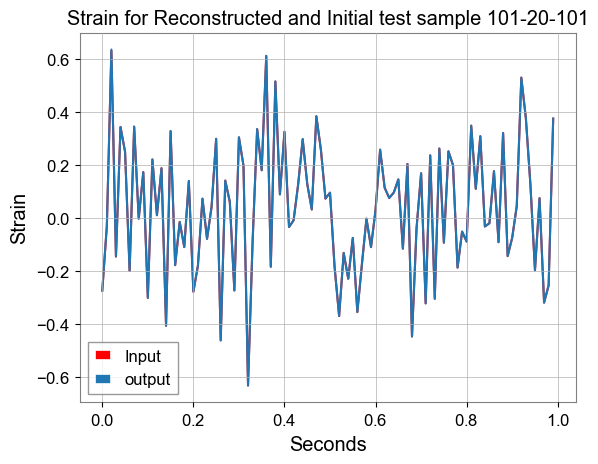

In [203]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,1,1/100)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_test


plt.plot(x, testData[0].numpy().flatten()[0:100], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:100], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial test sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

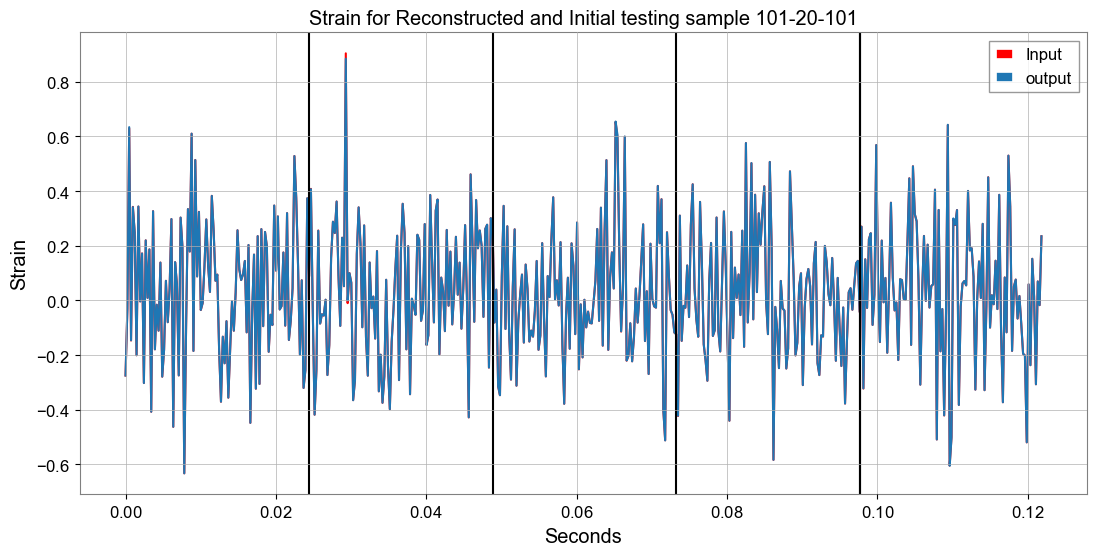

In [204]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,500/4096,1/4096)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_test

plt.figure(figsize=(13,6))
plt.plot(x, testData.numpy().flatten()[0:500], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:500], label = 'output')
plt.axvline(x = 100/4096, color = 'black')
plt.axvline(x = 200/4096, color = 'black')
plt.axvline(x = 300/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.axvline(x = 400/4096, color = 'black')
plt.legend()
plt.title('Strain for Reconstructed and Initial testing sample 101-20-101')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [27]:
data_BBH_tensored = torch.FloatTensor(data_injected_normalized)
decodedTestdata = autoencoder(data_BBH_tensored.unsqueeze(2))
decodedTestdata = decodedTestdata.double()
reconstructedData_BBH = decodedTestdata.detach().numpy()
ReconstructedError_BBH = torch.mean(((data_BBH_tensored.unsqueeze(2) - reconstructedData_BBH)**2),dim=1)
MSE_BBH = ReconstructedError_BBH.mean()

In [ ]:
data_BBH_tensored = torch.FloatTensor(data_injected_normalized)

reconstructedData_BBH = np.zeros((0, input_vector_length))
ReconstructedError_BBH = np.zeros((0))

Reconstruction_batchsize = 100
BBH_Data_batched = data_BBH_tensored.reshape(-1, Reconstruction_batchsize, input_vector_length)

for i in range(testData_batched.shape[0]):
    decodedTestdata = autoencoder(testData_batched[i].unsqueeze(2))
    decodedTestdata = decodedTestdata.double()
    reconstructedData_test_intermediate = decodedTestdata.detach().numpy()
    ReconstructedError_test_intermediate = torch.mean(((testData_batched[i].unsqueeze(2) - reconstructedData_test_intermediate)**2),dim=1)

    reconstructedData_test = np.append(reconstructedData_test, reconstructedData_test_intermediate)
    ReconstructedError_test = np.append(ReconstructedError_test, ReconstructedError_test_intermediate)

MSE_test = ReconstructedError_test.mean()

In [309]:
np.argmax(ReconstructedError_BBH)

tensor(2496)

Text(0, 0.5, 'Strain')

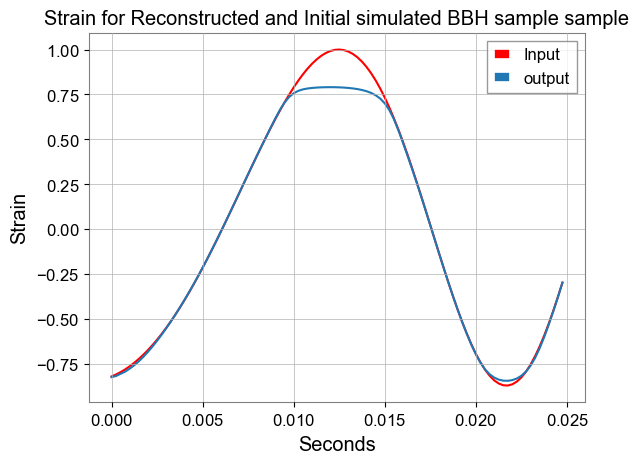

In [310]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,0.025,0.025/100)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_BBH[2496]


plt.plot(x, data_BBH_tensored[2496].numpy().flatten()[0:100], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:100], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial simulated BBH sample sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [16]:
data_SG_normalized,_ , _ = min_max_minus1_normalization(np.load('../Data_cached/4000Hz25mssampleSG7000.npy'))
data_real_glitches_normalized,_ , _ = min_max_minus1_normalization(np.load('../Data_cached/glitch_data_clean_25ms.npy'))
data_fake_glitches_normalized,_ , _ = min_max_minus1_normalization(np.load('../Data_cached/4000Hz25mssampleglitch7000.npy'))

In [32]:
# data_SG_normalized,_ , _ = bunch_min_max_minus1_normalization(np.load('../Data_cached/4000Hz25mssampleSG7000.npy'))
# data_real_glitches_normalized,_ , _ = bunch_min_max_minus1_normalization(np.load('../Data_cached/glitch_data_clean_25ms.npy'))
# data_fake_glitches_normalized,_ , _ = bunch_min_max_minus1_normalization(np.load('../Data_cached/4000Hz25mssampleglitch7000.npy'))
data_SG_normalized, _,_ = bunch_min_max_minus1_normalization(np.load('E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy')[:,0,:][70000:])
data_glitches_normalized, _, _ = bunch_min_max_minus1_normalization(np.load('../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz')['strain_time_data'])

In [33]:
data_SG_tensored = torch.FloatTensor(data_SG_normalized)
decodedTestdata = autoencoder(data_SG_tensored.unsqueeze(2))
decodedTestdata = decodedTestdata.double()
reconstructedData_SG = decodedTestdata.detach().numpy()
ReconstructedError_SG = torch.mean(((data_SG_tensored.unsqueeze(2) - reconstructedData_SG)**2),dim=1)
MSE_SG = ReconstructedError_SG.mean()

In [34]:
data_glitches_tensored = torch.FloatTensor(data_glitches_normalized)
decodedTestdata = autoencoder(data_glitches_tensored.unsqueeze(2))
decodedTestdata = decodedTestdata.double()
reconstructedData_glitches = decodedTestdata.detach().numpy()
ReconstructedError_glitches = torch.mean(((data_glitches_tensored.unsqueeze(2) - reconstructedData_glitches)**2),dim=1)
MSE_glitches = ReconstructedError_glitches.mean()

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 29355982848 bytes.

In [36]:
data_glitches_tensored = torch.FloatTensor(data_glitches_normalized[-30000:])

reconstructedData_glitches = np.zeros((0, input_vector_length))
ReconstructedError_glitches = np.zeros((0))

Reconstruction_batchsize = 100
glitches_Data_batched = data_glitches_tensored.reshape(-1, Reconstruction_batchsize, input_vector_length)

for i in range(glitches_Data_batched.shape[0]):
    decodedTestdata = autoencoder(glitches_Data_batched[i].unsqueeze(2))
    decodedTestdata = decodedTestdata.double()
    reconstructedData_glitches_intermediate = decodedTestdata.detach().numpy()
    ReconstructedError_glitches_intermediate = torch.mean(((glitches_Data_batched[i].unsqueeze(2) - reconstructedData_glitches_intermediate)**2),dim=1)

    reconstructedData_glitches = np.append(reconstructedData_glitches, reconstructedData_glitches_intermediate)
    ReconstructedError_glitches = np.append(ReconstructedError_glitches, ReconstructedError_glitches_intermediate)

MSE_glitches = ReconstructedError_glitches.mean()

In [366]:
data_real_glitches_tensored = torch.FloatTensor(data_real_glitches_normalized)
decodedTestdata = autoencoder(data_real_glitches_tensored.unsqueeze(2))
decodedTestdata = decodedTestdata.double()
reconstructedData_real_glitches = decodedTestdata.detach().numpy()
ReconstructedError_real_glitches = torch.mean(((data_real_glitches_tensored.unsqueeze(2) - reconstructedData_real_glitches)**2),dim=1)
MSE_real_glitches = ReconstructedError_real_glitches.mean()

In [367]:
data_fake_glitches_tensored = torch.FloatTensor(data_fake_glitches_normalized)
decodedTestdata = autoencoder(data_fake_glitches_tensored.unsqueeze(2))
decodedTestdata = decodedTestdata.double()
reconstructedData_fake_glitches = decodedTestdata.detach().numpy()
ReconstructedError_fake_glitches = torch.mean(((data_fake_glitches_tensored.unsqueeze(2) - reconstructedData_fake_glitches)**2),dim=1)
MSE_fake_glitches = ReconstructedError_fake_glitches.mean()

In [82]:
MSE_real_glitches

tensor(6.4667e-06, dtype=torch.float64)

In [156]:
ReconstructedError_fake_glitches.min()

tensor(0.0004, dtype=torch.float64)

In [302]:
np.argmax(ReconstructedError_SG)

tensor(886)

In [304]:
ReconstructedError_SG[886]

tensor([3.8900e-05], dtype=torch.float64)

Text(0, 0.5, 'Strain')

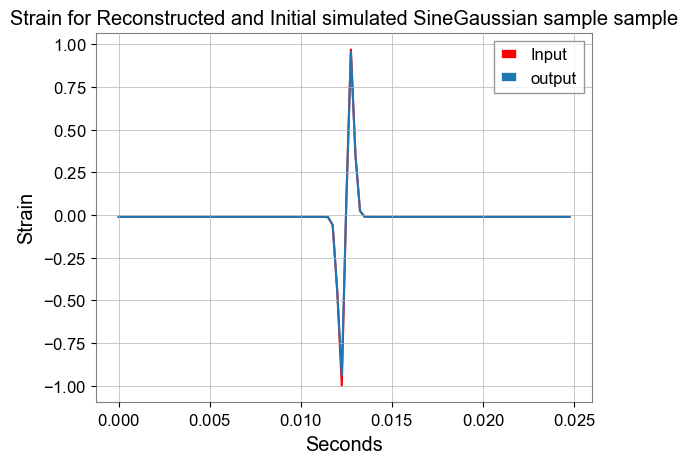

In [303]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,0.025,0.025/100)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_SG[886]


plt.plot(x, data_SG_tensored[886].numpy().flatten()[0:100], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:100], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial simulated SineGaussian sample sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [305]:
np.argmax(ReconstructedError_fake_glitches)

tensor(555)

Text(0, 0.5, 'Strain')

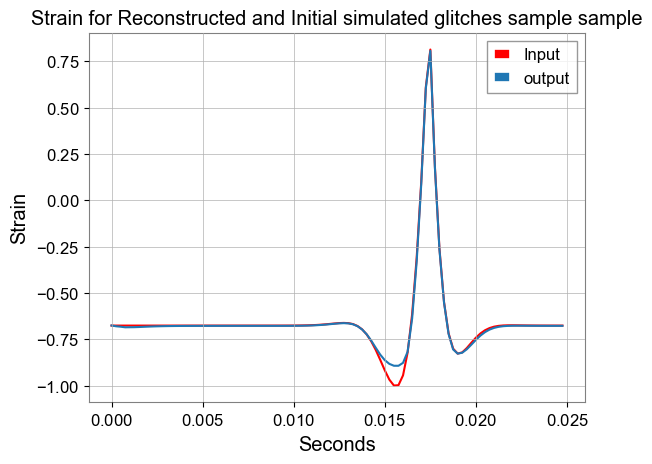

In [306]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,0.025,0.025/100)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_fake_glitches[555]


plt.plot(x, data_fake_glitches_tensored[555].numpy().flatten()[0:100], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:100], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial simulated glitches sample sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

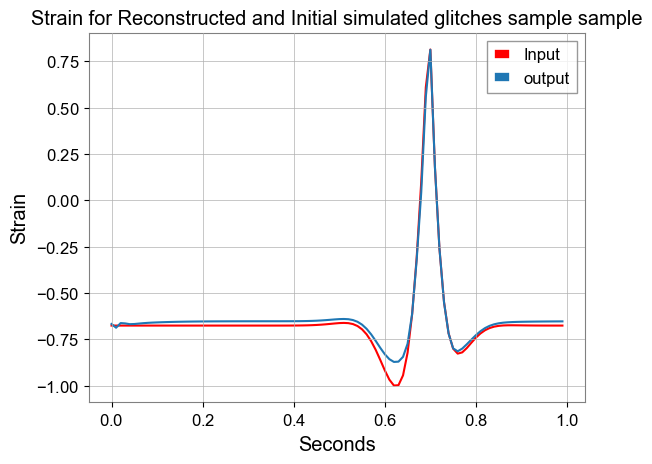

In [272]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,1,1/100)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_fake_glitches[555]


plt.plot(x, data_fake_glitches_tensored[555].numpy().flatten()[0:100], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:100], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial simulated glitches sample sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [96]:
ReconstructedError_real_glitches.max()

tensor(0.0005, dtype=torch.float64)

In [90]:
MSE_fake_glitches

tensor(2.3718e-05, dtype=torch.float64)

In [307]:
np.argmax(ReconstructedError_real_glitches)

tensor(103)

Text(0, 0.5, 'Strain')

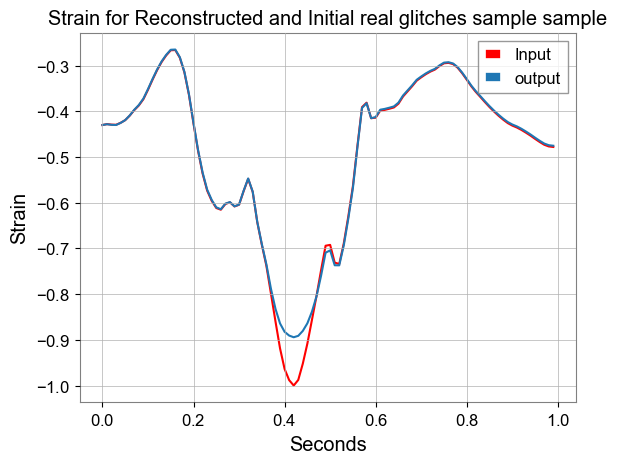

In [308]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,1,1/100)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_real_glitches[103]


plt.plot(x, data_real_glitches_tensored[103].numpy().flatten()[0:100], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:100], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial real glitches sample sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')

Text(0, 0.5, 'Strain')

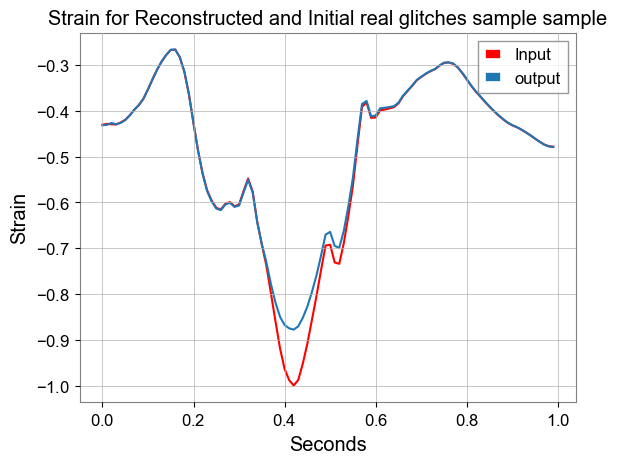

In [271]:
# x = np.arange(0, train_sample_number-1, 1/3)
x = np.arange(0,1,1/100)
y = np.zeros((train_sample_number-1, 3))
# for i in range(train_sample_number-1):
#     y[i] = reconstructedData[i] * X_train_recover_coef + X_train_recover_min
y = reconstructedData_real_glitches[103]


plt.plot(x, data_real_glitches_tensored[103].numpy().flatten()[0:100], color = 'red', label = 'Input')
plt.plot(x, y.flatten()[0:100], label = 'output')
plt.legend()
plt.title('Strain for Reconstructed and Initial real glitches sample sample')
plt.xlabel('Seconds')
plt.ylabel('Strain')

In [166]:
ReconstructedError_fake_glitches.min()

tensor(0.0004, dtype=torch.float64)

In [165]:
ReconstructedError_fake_glitches.max()

tensor(0.0011, dtype=torch.float64)

In [168]:
MSE_SG

tensor(6.5165e-07, dtype=torch.float64)

In [28]:
data_noise_tensored = torch.FloatTensor(data_noise_normalized)

reconstructedData_noise = np.zeros((0, input_vector_length))
ReconstructedError_noise = np.zeros((0))

Reconstruction_batchsize = 100
noise_Data_batched = data_noise_tensored.reshape(-1, Reconstruction_batchsize, input_vector_length)

for i in range(noise_Data_batched.shape[0]):
    decodedTestdata = autoencoder(noise_Data_batched[i].unsqueeze(2))
    decodedTestdata = decodedTestdata.double()
    reconstructedData_noise_intermediate = decodedTestdata.detach().numpy()
    ReconstructedError_noise_intermediate = torch.mean(((noise_Data_batched[i].unsqueeze(2) - reconstructedData_noise_intermediate)**2),dim=1)

    reconstructedData_noise = np.append(reconstructedData_noise, reconstructedData_noise_intermediate)
    ReconstructedError_noise = np.append(ReconstructedError_noise, ReconstructedError_noise_intermediate)

MSE_noise = ReconstructedError_noise.mean()

In [52]:
bin_scheme = np.arange(0, 5e-4, 1e-9)

counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_BBH, bins = bin_scheme)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_SG, bins = bin_scheme)
counts_real_glitches, bin_position_real_glitches = np.histogram(ReconstructedError_real_glitches, bins = bin_scheme)
counts_fake_glitches, bin_position_fake_glitches = np.histogram(ReconstructedError_fake_glitches, bins = bin_scheme)


In [239]:
bin_position_real_glitches[0]

0.0

In [54]:
counts_real_glitches.sum()

693

In [53]:
np.argwhere(counts_real_glitches == 1).shape

(21, 1)

(array([5., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([  1. ,  69.4, 137.8, 206.2, 274.6, 343. , 411.4, 479.8,
        548.2, 616.6, 685. ]),
 <BarContainer object of 10 artists>)

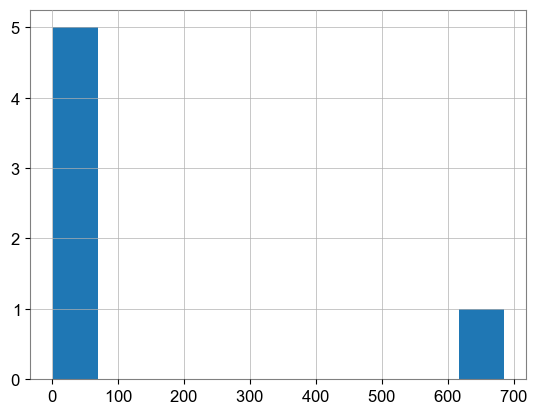

In [48]:
plt.hist(counts_real_glitches[counts_real_glitches > 0])

(array([23.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([  1. ,  23.8,  46.6,  69.4,  92.2, 115. , 137.8, 160.6,
        183.4, 206.2, 229. ]),
 <BarContainer object of 10 artists>)

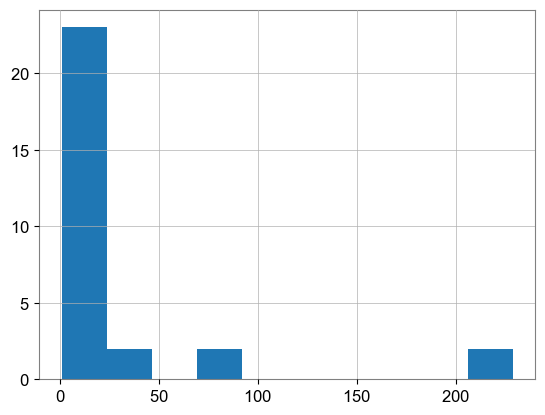

In [328]:
plt.hist(counts_real_glitches[counts_real_glitches > 0])

(array([3.836e+03, 6.610e+02, 2.350e+02, 9.400e+01, 0.000e+00,
        4.400e+01, 2.200e+01, 5.000e+00, 4.000e+00, 1.000e+00]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. , 5.8, 6.6, 7.4, 8.2, 9. ]),
 <BarContainer object of 10 artists>)

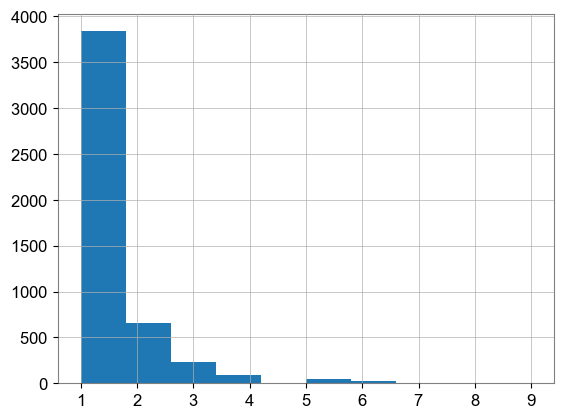

In [329]:
plt.hist(counts_fake_glitches[counts_fake_glitches > 0])

In [ ]:
plt.plot(bin, counts_fake_glitches)

Below are the analysis for non-bunch version of LSTM

(array([820.,  11.,   4.,   5.,   4.,   0.,   1.,   0.,   0.,
          1.]),
 array([  1. ,  59.3, 117.6, 175.9, 234.2, 292.5, 350.8, 409.1,
        467.4, 525.7, 584. ]),
 <BarContainer object of 10 artists>)

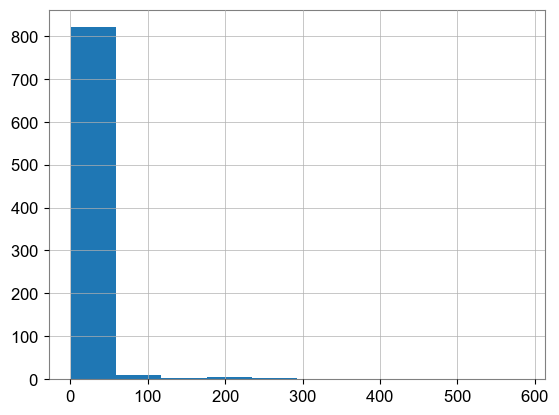

In [288]:
plt.hist(counts_sinegaussian[counts_sinegaussian > 0])

(array([2625.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,   46.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

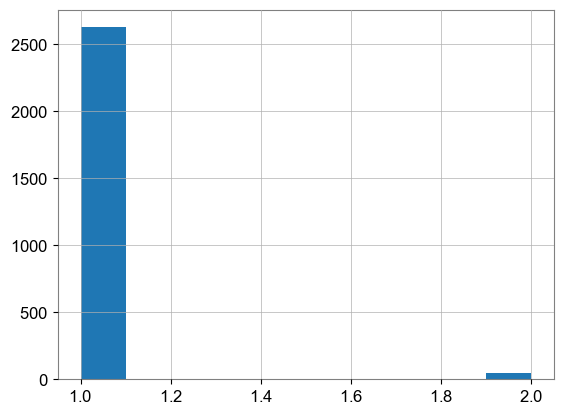

In [287]:
plt.hist(counts_fake_glitches[counts_fake_glitches > 0])

(array([22.,  1.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  2.]),
 array([  1. ,  17.5,  34. ,  50.5,  67. ,  83.5, 100. , 116.5,
        133. , 149.5, 166. ]),
 <BarContainer object of 10 artists>)

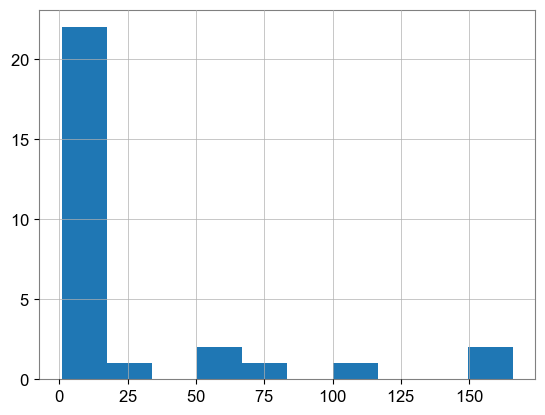

In [241]:
plt.hist(counts_real_glitches[counts_real_glitches > 0])

In [238]:
bin_position_real_glitches.shape

(500000,)

In [244]:
bin_position_real_glitches[np.argwhere(counts_real_glitches > 150)]

array([[2.474e-06],
       [2.475e-06]])

In [249]:
bin_position_real_glitches[np.argwhere((counts_real_glitches > 100) & (counts_real_glitches < 150))]

array([[2.476e-06]])

In [250]:
bin_position_real_glitches[np.argwhere((counts_real_glitches > 50) & (counts_real_glitches < 100))]

array([[2.472e-06],
       [2.473e-06],
       [2.477e-06]])

In [252]:
bin_position_real_glitches[np.argwhere((counts_real_glitches > 1) & (counts_real_glitches < 50))]

array([[2.470e-06],
       [2.471e-06],
       [2.478e-06],
       [2.479e-06],
       [2.480e-06]])

In [255]:
bin_position_real_glitches[np.argwhere((counts_real_glitches == 1))].shape[0]

18

In [353]:
np.savez('../Data_cached/LSTM_1e6_error_data.npz', train = ReconstructedError_train, test = ReconstructedError_test, BBH = ReconstructedError_BBH, SG = ReconstructedError_SG, real_glitches = ReconstructedError_real_glitches, simulated_glitches = ReconstructedError_fake_glitches)

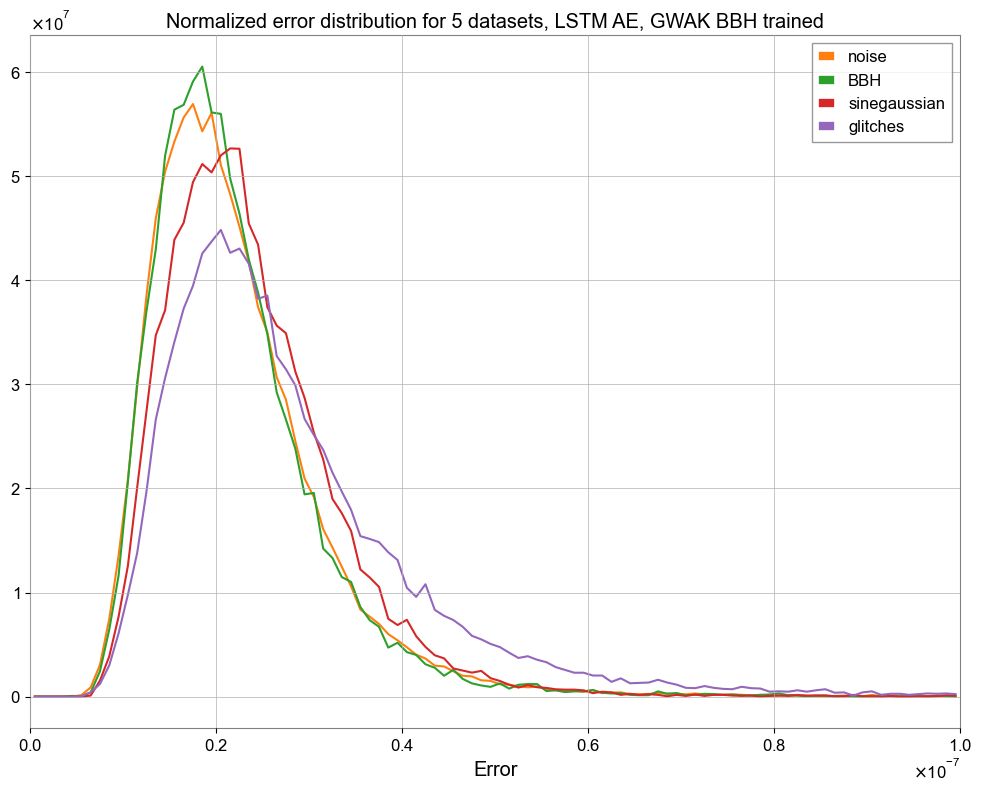

In [40]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(0, 1e-7, 1e-7/100)


# counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
# counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_noise, bin_position_noise = np.histogram(ReconstructedError_noise, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_BBH, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_SG, bins = bin_scheme, density = True)
counts_glitches, bin_position_glitches = np.histogram(ReconstructedError_glitches, bins = bin_scheme, density = True)
# counts_fake_glitches, bin_position_fake_glitches = np.histogram(ReconstructedError_fake_glitches, bins = bin_scheme, density = True)

# bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
# bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_noise = (bin_position_noise[:-1] + bin_position_noise[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_glitches = (bin_position_glitches[:-1] + bin_position_glitches[1:]) / 2
# bin_centers_fake_glitches = (bin_position_fake_glitches[:-1] + bin_position_fake_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
# plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
# plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_noise, counts_noise, color = colors[1], label = 'noise')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'sinegaussian')
plt.plot(bin_centers_glitches, counts_glitches, color = colors[4], label = 'glitches')
# plt.plot(bin_centers_fake_glitches, 10 * counts_fake_glitches, color = colors[5], label = 'Signal sample - simulated glitches')


# plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
# plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
# plt.axvline(x = MSE_BBH, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_SG, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_glitches, color = colors[4], linestyle = '--', label = 'Signal sample MSE - glitches')
# plt.axvline(x = MSE_fake_glitches, color = colors[5], linestyle = '--', label = 'Signal sample MSE - simulated glitches')


plt.xlim(0, 1e-7)
# plt.ylim(0, 7e7)
plt.xlabel('Error')
plt.title('Normalized error distribution for 5 datasets, LSTM AE, GWAK BBH trained')
plt.legend()
plt.show()

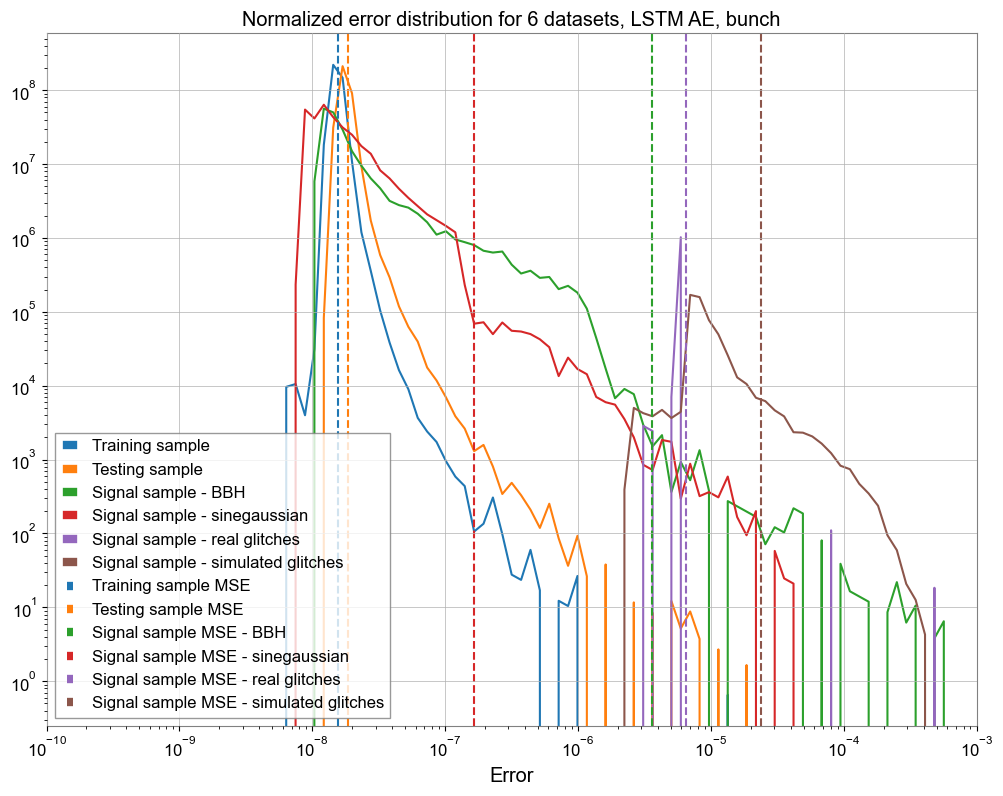

In [352]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(0, 5e-4, 1e-9)
bin_scheme = np.logspace(-10, -3, 100)


counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_BBH, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_SG, bins = bin_scheme, density = True)
counts_real_glitches, bin_position_real_glitches = np.histogram(ReconstructedError_real_glitches, bins = bin_scheme, density = True)
counts_fake_glitches, bin_position_fake_glitches = np.histogram(ReconstructedError_fake_glitches, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_real_glitches = (bin_position_real_glitches[:-1] + bin_position_real_glitches[1:]) / 2
bin_centers_fake_glitches = (bin_position_fake_glitches[:-1] + bin_position_fake_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_real_glitches, counts_real_glitches, color = colors[4], label = 'Signal sample - real glitches')
plt.plot(bin_centers_fake_glitches, counts_fake_glitches, color = colors[5], label = 'Signal sample - simulated glitches')


plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_BBH, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_SG, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_real_glitches, color = colors[4], linestyle = '--', label = 'Signal sample MSE - real glitches')
plt.axvline(x = MSE_fake_glitches, color = colors[5], linestyle = '--', label = 'Signal sample MSE - simulated glitches')


plt.xlim(1e-10, 1e-3)
# plt.ylim(1e-10, 1e8)
# plt.ylim(0, 7e7)
plt.xlabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.title('Normalized error distribution for 6 datasets, LSTM AE, bunch')
plt.legend()
plt.show()

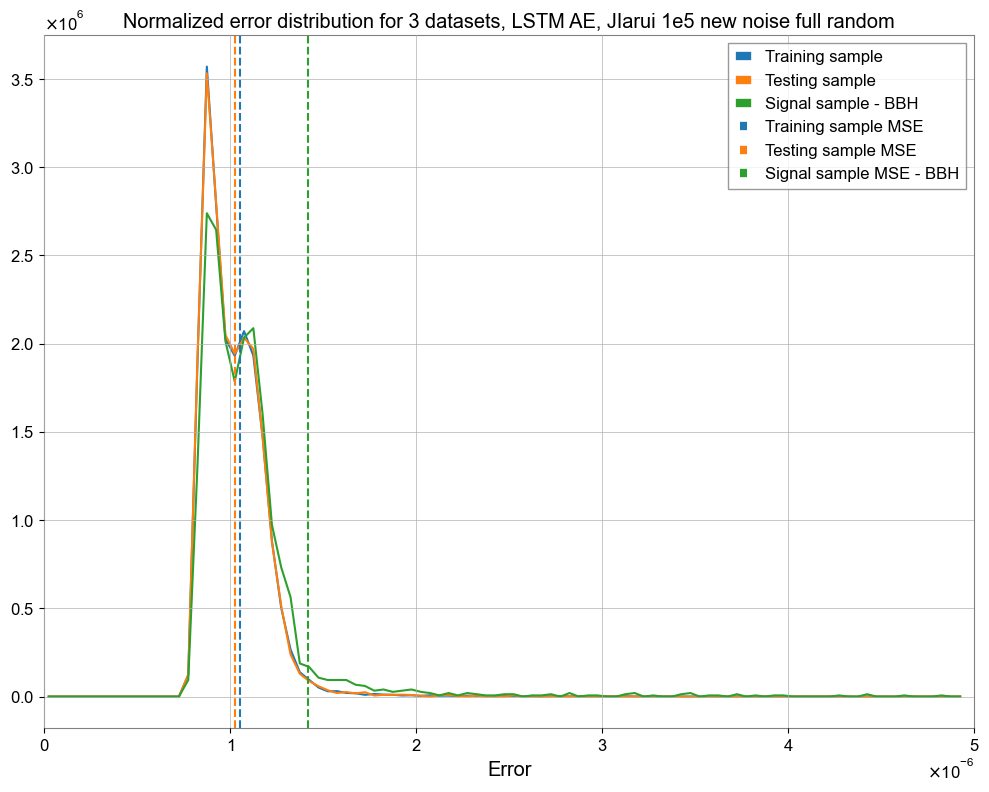

In [31]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(0, 5e-6, 5e-6/100)


counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_BBH, bins = bin_scheme, density = True)
# counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_SG, bins = bin_scheme, density = True)
# counts_real_glitches, bin_position_real_glitches = np.histogram(ReconstructedError_real_glitches, bins = bin_scheme, density = True)
# counts_fake_glitches, bin_position_fake_glitches = np.histogram(ReconstructedError_fake_glitches, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
# bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
# bin_centers_real_glitches = (bin_position_real_glitches[:-1] + bin_position_real_glitches[1:]) / 2
# bin_centers_fake_glitches = (bin_position_fake_glitches[:-1] + bin_position_fake_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
# plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
# plt.plot(bin_centers_real_glitches, counts_real_glitches, color = colors[4], label = 'Signal sample - real glitches')
# plt.plot(bin_centers_fake_glitches, 10 * counts_fake_glitches, color = colors[5], label = 'Signal sample - simulated glitches')


plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_BBH, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
# plt.axvline(x = MSE_SG, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
# plt.axvline(x = MSE_real_glitches, color = colors[4], linestyle = '--', label = 'Signal sample MSE - real glitches')
# plt.axvline(x = MSE_fake_glitches, color = colors[5], linestyle = '--', label = 'Signal sample MSE - simulated glitches')


plt.xlim(0, 5e-6)
# plt.ylim(0, 7e7)
plt.xlabel('Error')
plt.title('Normalized error distribution for 3 datasets, LSTM AE, JIarui 1e5 new noise full random')
plt.legend()
plt.show()

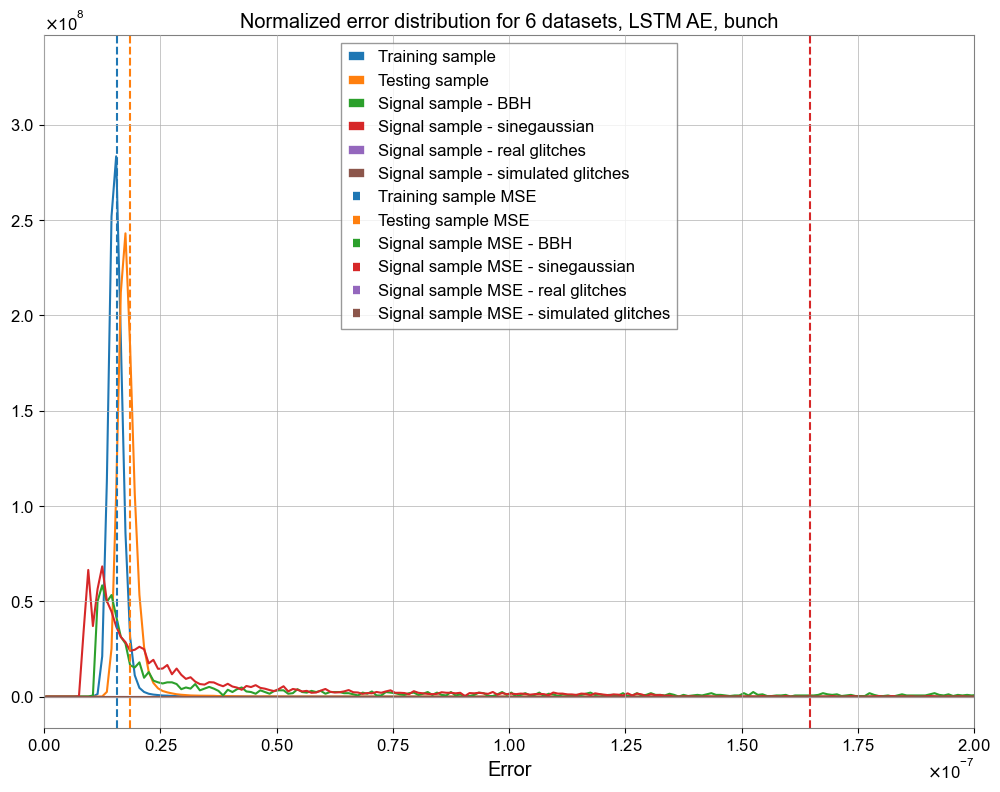

In [348]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(0, 5e-4, 1e-9)


counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_BBH, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_SG, bins = bin_scheme, density = True)
counts_real_glitches, bin_position_real_glitches = np.histogram(ReconstructedError_real_glitches, bins = bin_scheme, density = True)
counts_fake_glitches, bin_position_fake_glitches = np.histogram(ReconstructedError_fake_glitches, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_real_glitches = (bin_position_real_glitches[:-1] + bin_position_real_glitches[1:]) / 2
bin_centers_fake_glitches = (bin_position_fake_glitches[:-1] + bin_position_fake_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_real_glitches, counts_real_glitches, color = colors[4], label = 'Signal sample - real glitches')
plt.plot(bin_centers_fake_glitches, 10 * counts_fake_glitches, color = colors[5], label = 'Signal sample - simulated glitches')


plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_BBH, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_SG, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_real_glitches, color = colors[4], linestyle = '--', label = 'Signal sample MSE - real glitches')
plt.axvline(x = MSE_fake_glitches, color = colors[5], linestyle = '--', label = 'Signal sample MSE - simulated glitches')


plt.xlim(0, 2e-7)
# plt.ylim(0, 7e7)
plt.xlabel('Error')
plt.title('Normalized error distribution for 6 datasets, LSTM AE, bunch')
plt.legend()
plt.show()

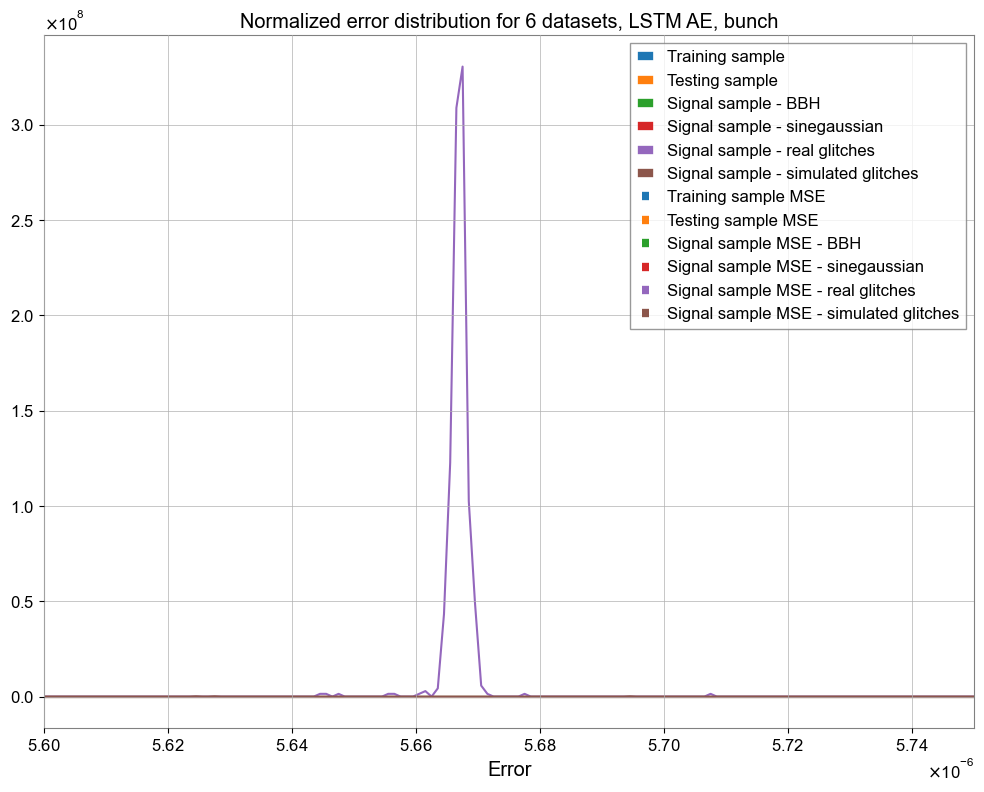

In [344]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(0, 5e-4, 1e-9)


counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_BBH, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_SG, bins = bin_scheme, density = True)
counts_real_glitches, bin_position_real_glitches = np.histogram(ReconstructedError_real_glitches, bins = bin_scheme, density = True)
counts_fake_glitches, bin_position_fake_glitches = np.histogram(ReconstructedError_fake_glitches, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_real_glitches = (bin_position_real_glitches[:-1] + bin_position_real_glitches[1:]) / 2
bin_centers_fake_glitches = (bin_position_fake_glitches[:-1] + bin_position_fake_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_real_glitches, counts_real_glitches, color = colors[4], label = 'Signal sample - real glitches')
plt.plot(bin_centers_fake_glitches, counts_fake_glitches, color = colors[5], label = 'Signal sample - simulated glitches')


plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_BBH, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_SG, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_real_glitches, color = colors[4], linestyle = '--', label = 'Signal sample MSE - real glitches')
plt.axvline(x = MSE_fake_glitches, color = colors[5], linestyle = '--', label = 'Signal sample MSE - simulated glitches')


plt.xlim(5.6e-6, 5.75e-6)
# plt.ylim(0, 7e7)
plt.xlabel('Error')
plt.title('Normalized error distribution for 6 datasets, LSTM AE, bunch')
plt.legend()
plt.show()

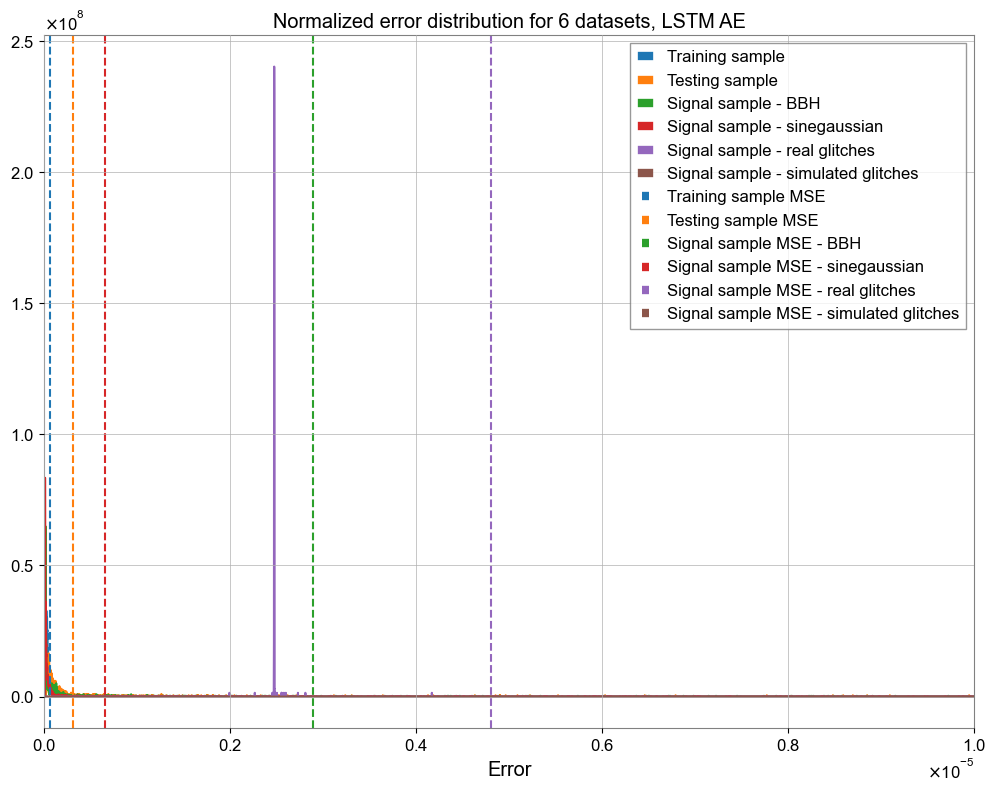

In [381]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(0, 5e-4, 1e-9)


counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_BBH, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_SG, bins = bin_scheme, density = True)
counts_real_glitches, bin_position_real_glitches = np.histogram(ReconstructedError_real_glitches, bins = bin_scheme, density = True)
counts_fake_glitches, bin_position_fake_glitches = np.histogram(ReconstructedError_fake_glitches, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_real_glitches = (bin_position_real_glitches[:-1] + bin_position_real_glitches[1:]) / 2
bin_centers_fake_glitches = (bin_position_fake_glitches[:-1] + bin_position_fake_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_real_glitches, counts_real_glitches, color = colors[4], label = 'Signal sample - real glitches')
plt.plot(bin_centers_fake_glitches, 100 * counts_fake_glitches, color = colors[5], label = 'Signal sample - simulated glitches')


plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_BBH, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_SG, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_real_glitches, color = colors[4], linestyle = '--', label = 'Signal sample MSE - real glitches')
plt.axvline(x = MSE_fake_glitches, color = colors[5], linestyle = '--', label = 'Signal sample MSE - simulated glitches')


plt.xlim(0, 1e-5)
# plt.ylim(0, 7e7)
plt.xlabel('Error')
plt.title('Normalized error distribution for 6 datasets, LSTM AE')
plt.legend()
plt.show()

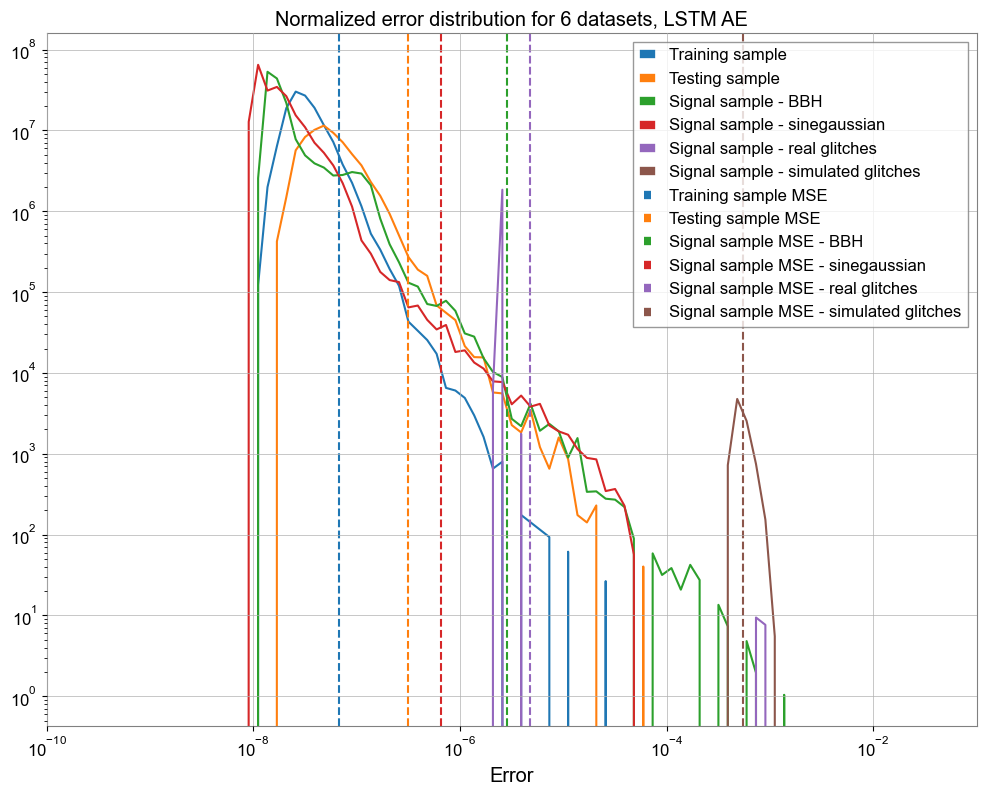

In [370]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(0, 5e-4, 1e-9)
bin_scheme = np.logspace(-10, -1, 100)


counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_BBH, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_SG, bins = bin_scheme, density = True)
counts_real_glitches, bin_position_real_glitches = np.histogram(ReconstructedError_real_glitches, bins = bin_scheme, density = True)
counts_fake_glitches, bin_position_fake_glitches = np.histogram(ReconstructedError_fake_glitches, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_real_glitches = (bin_position_real_glitches[:-1] + bin_position_real_glitches[1:]) / 2
bin_centers_fake_glitches = (bin_position_fake_glitches[:-1] + bin_position_fake_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_real_glitches, counts_real_glitches, color = colors[4], label = 'Signal sample - real glitches')
plt.plot(bin_centers_fake_glitches, counts_fake_glitches, color = colors[5], label = 'Signal sample - simulated glitches')


plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_BBH, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_SG, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_real_glitches, color = colors[4], linestyle = '--', label = 'Signal sample MSE - real glitches')
plt.axvline(x = MSE_fake_glitches, color = colors[5], linestyle = '--', label = 'Signal sample MSE - simulated glitches')


plt.xlim(1e-10, 1e-1)
# plt.ylim(1e-10, 1e8)
# plt.ylim(0, 7e7)
plt.xlabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.title('Normalized error distribution for 6 datasets, LSTM AE')
plt.legend()
plt.show()

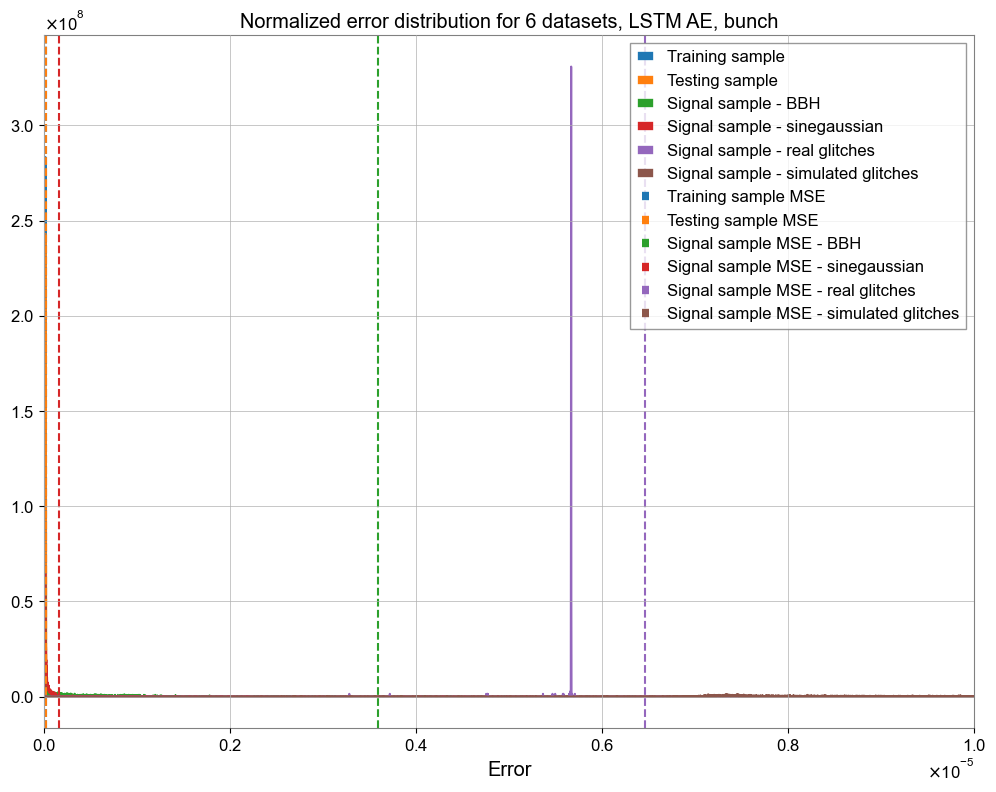

In [317]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
bin_scheme = np.arange(0, 1e-4, 1e-9)


counts_train, bin_position_train = np.histogram(ReconstructedError_train, bins = bin_scheme, density = True)
counts_test, bin_position_test = np.histogram(ReconstructedError_test, bins = bin_scheme, density = True)
counts_signal, bin_position_signal = np.histogram(ReconstructedError_BBH, bins = bin_scheme, density = True)
counts_sinegaussian, bin_position_sinegaussian = np.histogram(ReconstructedError_SG, bins = bin_scheme, density = True)
counts_real_glitches, bin_position_real_glitches = np.histogram(ReconstructedError_real_glitches, bins = bin_scheme, density = True)
counts_fake_glitches, bin_position_fake_glitches = np.histogram(ReconstructedError_fake_glitches, bins = bin_scheme, density = True)

bin_centers_train = (bin_position_train[:-1] + bin_position_train[1:]) / 2
bin_centers_test = (bin_position_test[:-1] + bin_position_test[1:]) / 2
bin_centers_signal = (bin_position_signal[:-1] + bin_position_signal[1:]) / 2
bin_centers_sinegaussian = (bin_position_sinegaussian[:-1] + bin_position_sinegaussian[1:]) / 2
bin_centers_real_glitches = (bin_position_real_glitches[:-1] + bin_position_real_glitches[1:]) / 2
bin_centers_fake_glitches = (bin_position_fake_glitches[:-1] + bin_position_fake_glitches[1:]) / 2


plt.figure(figsize=(12, 9))
plt.plot(bin_centers_train, counts_train, color = colors[0], label = 'Training sample')
plt.plot(bin_centers_test, counts_test, color = colors[1], label = 'Testing sample')
plt.plot(bin_centers_signal, counts_signal, color = colors[2], label = 'Signal sample - BBH')
plt.plot(bin_centers_sinegaussian, counts_sinegaussian, color = colors[3], label = 'Signal sample - sinegaussian')
plt.plot(bin_centers_real_glitches, counts_real_glitches, color = colors[4], label = 'Signal sample - real glitches')
plt.plot(bin_centers_fake_glitches, counts_fake_glitches, color = colors[5], label = 'Signal sample - simulated glitches')


plt.axvline(x = MSE_train, color = colors[0], linestyle = '--', label = 'Training sample MSE')
plt.axvline(x = MSE_test, color = colors[1], linestyle = '--', label = 'Testing sample MSE')
plt.axvline(x = MSE_BBH, color = colors[2], linestyle = '--', label = 'Signal sample MSE - BBH')
plt.axvline(x = MSE_SG, color = colors[3], linestyle = '--', label = 'Signal sample MSE - sinegaussian')
plt.axvline(x = MSE_real_glitches, color = colors[4], linestyle = '--', label = 'Signal sample MSE - real glitches')
plt.axvline(x = MSE_fake_glitches, color = colors[5], linestyle = '--', label = 'Signal sample MSE - simulated glitches')


plt.xlim(0, 1e-5)
plt.xlabel('Error')
plt.title('Normalized error distribution for 6 datasets, LSTM AE, bunch')
plt.legend()
plt.show()

In [62]:
np.sort(ReconstructedError_train, axis=None)[-7000]

2.0641819217169883e-08

In [65]:
np.sort(ReconstructedError_train, axis=None)[7000]

1.2664128602062333e-08

In [69]:
np.argwhere(ReconstructedError_BBH.flatten() > 2.0641819217169883e-08).shape[1] / len(ReconstructedError_BBH)

0.6425582785415421

In [113]:
np.argwhere(ReconstructedError_BBH.numpy().flatten() > 2.0641819217169883e-08).shape

(2150, 1)

In [68]:
np.argwhere(ReconstructedError_BBH.flatten() < 1.2664128602062333e-08).shape[1] / len(ReconstructedError_BBH)

0.08696951583980873

In [59]:
MSE_BBH

tensor(3.5881e-06, dtype=torch.float64)

In [220]:
ReconstructedError_train.shape

torch.Size([7000, 1])

In [236]:
np.sort(ReconstructedError_train, axis=None)[-70]

4.7587205319799874e-07

In [242]:
ReconstructedError_BBH > 0

tensor([[True],
        [True],
        [True],
        ...,
        [True],
        [True],
        [True]])

In [250]:
np.argwhere(ReconstructedError_BBH.flatten() > 0)

tensor([[   0,    1,    2,  ..., 3343, 3344, 3345]])

In [251]:
np.argwhere(ReconstructedError_BBH.flatten() > 0).shape[1]

3346

In [253]:
np.argwhere(ReconstructedError_BBH.flatten() > 4.7587205319799874e-07).shape[1] / len(ReconstructedError_BBH)

0.10639569635385535

Proper ROC study here
---

Upper side FPR

In [185]:
def upperTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    # print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    # print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        threshold = np.sort(trainerror)[-index_number]
            
        # print(threshold)
        # print(np.argwhere(signalerror > threshold).shape)
        TPRlist[i] = np.argwhere(signalerror > threshold).shape[0] / length_of_signal_value
    
    return TPRlist

In [225]:
def lowerTPRFPRcalc(trainerror, signalerror, FPRlist):
    TPRlist = np.zeros(len(FPRlist))
    length_of_train_sample = len(trainerror)
    # print(length_of_train_sample)
    length_of_signal_value = len(signalerror)
    # print(length_of_signal_value)
    
    for i in range(len(FPRlist)):
        index_number = int(length_of_train_sample * FPRlist[i])
        if index_number == 0:
            threshold = np.sort(trainerror)[index_number]
        else:
            threshold = np.sort(trainerror)[index_number-1]
        # print(np.sort(trainerror))
        # print(threshold)
        # print(np.argwhere(signalerror < threshold).shape)
        TPRlist[i] = np.argwhere(signalerror < threshold).shape[0] / length_of_signal_value
    
    return TPRlist

In [216]:
np.sort(ReconstructedError_train.numpy().flatten())[-7]

2.7425373553100082e-06

In [219]:
np.argwhere(ReconstructedError_BBH.numpy().flatten() > 2.7425373553100082e-06).shape

(138, 1)

In [220]:
138/3346

0.041243275552898986

In [200]:
np.argwhere(ReconstructedError_BBH.numpy().flatten() < 1.3352199816184821e-08).shape[0] / len(ReconstructedError_BBH)

0.045427375971309025

In [212]:
lowerTPRFPRcalc(ReconstructedError_train.numpy().flatten(), ReconstructedError_BBH.numpy().flatten(), np.array([0.001]))

array([0.04542738])

In [221]:
upperTPRFPRcalc(ReconstructedError_train.numpy().flatten(), ReconstructedError_BBH.numpy().flatten(), np.array([0.001]))

array([0.04124328])

In [123]:
FPR_list = np.logspace(-3, 0, 30)

In [324]:
TPR_list_test = upperTPRFPRcalc(ReconstructedError_train, ReconstructedError_test, FPR_list)
TPR_list_BBH = upperTPRFPRcalc(ReconstructedError_train, ReconstructedError_BBH.numpy().flatten(), FPR_list)
TPR_list_SG = upperTPRFPRcalc(ReconstructedError_train, ReconstructedError_SG.numpy().flatten(), FPR_list)
TPR_list_real_glitches = upperTPRFPRcalc(ReconstructedError_train, ReconstructedError_real_glitches.numpy().flatten(), FPR_list)
TPR_list_fake_glitches = upperTPRFPRcalc(ReconstructedError_train, ReconstructedError_fake_glitches.numpy().flatten(), FPR_list)

In [321]:
TPR_list_test = lowerTPRFPRcalc(ReconstructedError_train, ReconstructedError_test, FPR_list)
TPR_list_BBH = lowerTPRFPRcalc(ReconstructedError_train, ReconstructedError_BBH.numpy().flatten(), FPR_list)
TPR_list_SG = lowerTPRFPRcalc(ReconstructedError_train, ReconstructedError_SG.numpy().flatten(), FPR_list)
TPR_list_real_glitches = lowerTPRFPRcalc(ReconstructedError_train, ReconstructedError_real_glitches.numpy().flatten(), FPR_list)
TPR_list_fake_glitches = lowerTPRFPRcalc(ReconstructedError_train, ReconstructedError_fake_glitches.numpy().flatten(), FPR_list)

In [259]:
TPR_list_test = upperTPRFPRcalc(ReconstructedError_train.numpy().flatten(), ReconstructedError_test.numpy().flatten(), FPR_list)
TPR_list_BBH = upperTPRFPRcalc(ReconstructedError_train.numpy().flatten(), ReconstructedError_BBH.numpy().flatten(), FPR_list)
TPR_list_SG = upperTPRFPRcalc(ReconstructedError_train.numpy().flatten(), ReconstructedError_SG.numpy().flatten(), FPR_list)
TPR_list_real_glitches = upperTPRFPRcalc(ReconstructedError_train.numpy().flatten(), ReconstructedError_real_glitches.numpy().flatten(), FPR_list)
TPR_list_fake_glitches = upperTPRFPRcalc(ReconstructedError_train.numpy().flatten(), ReconstructedError_fake_glitches.numpy().flatten(), FPR_list)

In [264]:
TPR_list_test = lowerTPRFPRcalc(ReconstructedError_train.numpy().flatten(), ReconstructedError_test.numpy().flatten(), FPR_list)
TPR_list_BBH = lowerTPRFPRcalc(ReconstructedError_train.numpy().flatten(), ReconstructedError_BBH.numpy().flatten(), FPR_list)
TPR_list_SG = lowerTPRFPRcalc(ReconstructedError_train.numpy().flatten(), ReconstructedError_SG.numpy().flatten(), FPR_list)
TPR_list_real_glitches = lowerTPRFPRcalc(ReconstructedError_train.numpy().flatten(), ReconstructedError_real_glitches.numpy().flatten(), FPR_list)
TPR_list_fake_glitches = lowerTPRFPRcalc(ReconstructedError_train.numpy().flatten(), ReconstructedError_fake_glitches.numpy().flatten(), FPR_list)

In [325]:
TPR_list_test[-1] = 1
TPR_list_BBH[-1] = 1
TPR_list_SG[-1] = 1
TPR_list_real_glitches[-1] = 1
TPR_list_fake_glitches[-1] = 1

Text(0.5, 1.0, 'ROC curve for LSTM AE, upper side')

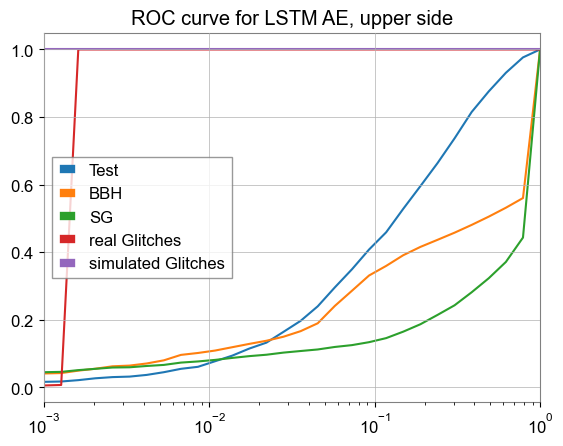

In [261]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.plot(FPR_list, TPR_list_test, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_list_BBH, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_list_SG, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_list_real_glitches, color = colors[3], label = 'real Glitches')
plt.plot(FPR_list, TPR_list_fake_glitches, color = colors[4], label = 'simulated Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('ROC curve for LSTM AE, upper side')

Text(0.5, 1.0, 'ROC curve for LSTM AE, lower side')

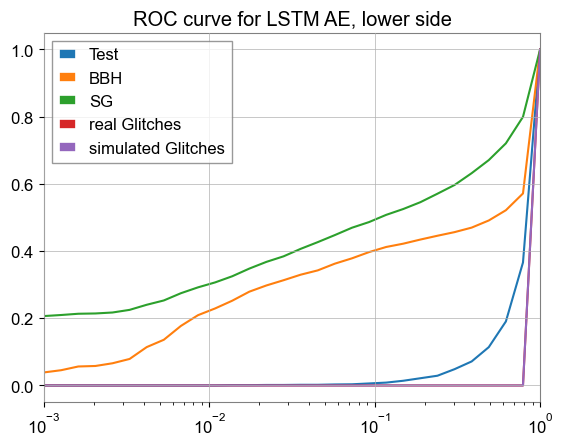

In [266]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.plot(FPR_list, TPR_list_test, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_list_BBH, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_list_SG, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_list_real_glitches, color = colors[3], label = 'real Glitches')
plt.plot(FPR_list, TPR_list_fake_glitches, color = colors[4], label = 'simulated Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('ROC curve for LSTM AE, lower side')

Text(0.5, 1.0, 'ROC curve for LSTM AE, bunch version, upper side')

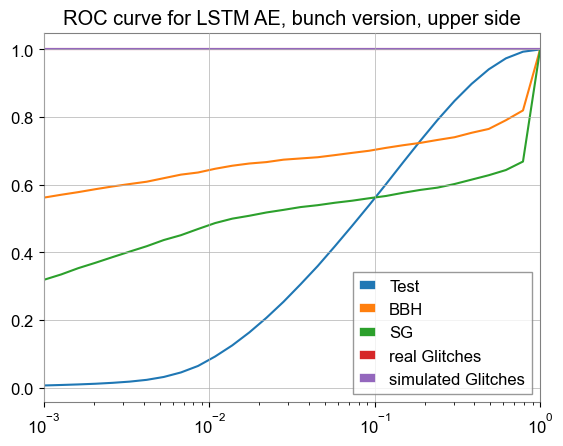

In [326]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.plot(FPR_list, TPR_list_test, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_list_BBH, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_list_SG, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_list_real_glitches, color = colors[3], label = 'real Glitches')
plt.plot(FPR_list, TPR_list_fake_glitches, color = colors[4], label = 'simulated Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('ROC curve for LSTM AE, bunch version, upper side')

Text(0.5, 1.0, 'ROC curve for LSTM AE, bunch version, lower side')

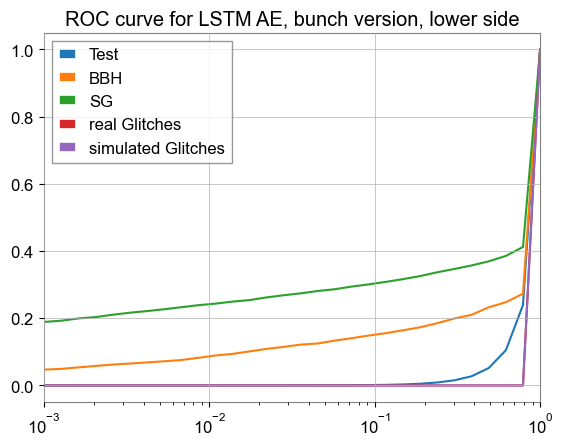

In [323]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.plot(FPR_list, TPR_list_test, color = colors[0], label = 'Test')
plt.plot(FPR_list, TPR_list_BBH, color = colors[1], label = 'BBH')
plt.plot(FPR_list, TPR_list_SG, color = colors[2], label = 'SG')
plt.plot(FPR_list, TPR_list_real_glitches, color = colors[3], label = 'real Glitches')
plt.plot(FPR_list, TPR_list_fake_glitches, color = colors[4], label = 'simulated Glitches')

plt.xlim(1e-3, 1e0)
plt.xscale('log')
plt.yscale('linear')
plt.legend()
plt.title('ROC curve for LSTM AE, bunch version, lower side')

In [382]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [383]:
count_parameters(autoencoder)

11233